In [1]:
import mpmath as mpm
import numpy as np
def Chbshv_poly(L, x): # Lth Chebyshev polynomial of the first kind
    return mpm.cos(L * mpm.acos(x))

In [2]:
# Input parameters for the Fixed-Point Grover's search
n = 2 # Number of qubits, does not include the last ancillary qubit
indices_to_mark = 2 # An interger from 0 to 2**n

itr = 1 # Number of iterations
d = mpm.sqrt(0.2) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

In [3]:
# Compute the rest of parameters
l = itr
L = 2*l+1

gamma_inverse = Chbshv_poly(1/L, 1/d)
omega = 1 - Chbshv_poly(1/L, 1/d)**(-2)

alpha =  mpm.zeros(1,l)
beta = mpm.zeros(1,l)
for i in range(l): # use i instead of j since python use 1j for sqrt(-1)
    alpha[i] = 2*mpm.acot(mpm.tan(2*mpm.pi*(i+1)/L) * mpm.sqrt(1-1/gamma_inverse**2))
    beta[l-(i+1)+1-1] = -alpha[i]
    
# Convert to numpy
gamma_inverse = np.array([gamma_inverse], dtype=complex)[0].real
omega = np.array([omega], dtype=complex)[0].real
alpha = np.array(alpha.tolist()[0], dtype=complex).real
beta = np.array(beta.tolist()[0], dtype=complex).real

print("gamma^-1 = ", gamma_inverse)
print("lambda = ", 1/2**n)
print("Omega = ", omega)
print("alpha", alpha)
print("beta", beta)

gamma^-1 =  1.118033988749895
lambda =  0.25
Omega =  0.20000000000000007
alpha [-1.82347658]
beta [1.82347658]


In [4]:
def oracle(qc,n, indices_to_mark):
    # create a quantum circuit on n qubits
    index_bit =  format(indices_to_mark, "0{:d}b".format(n))
    qc.barrier()
    for i in range(n):
        if index_bit[i] == '0':
            qc.x(i)
    qc.mct(list(range(n)), n)
    for i in range(n): # Redo the NOT gates applied on control qubits
        if index_bit[i] == '0':
            qc.x(i) 
    qc.barrier()

Looking for  10
1-delta^2 =  0.8


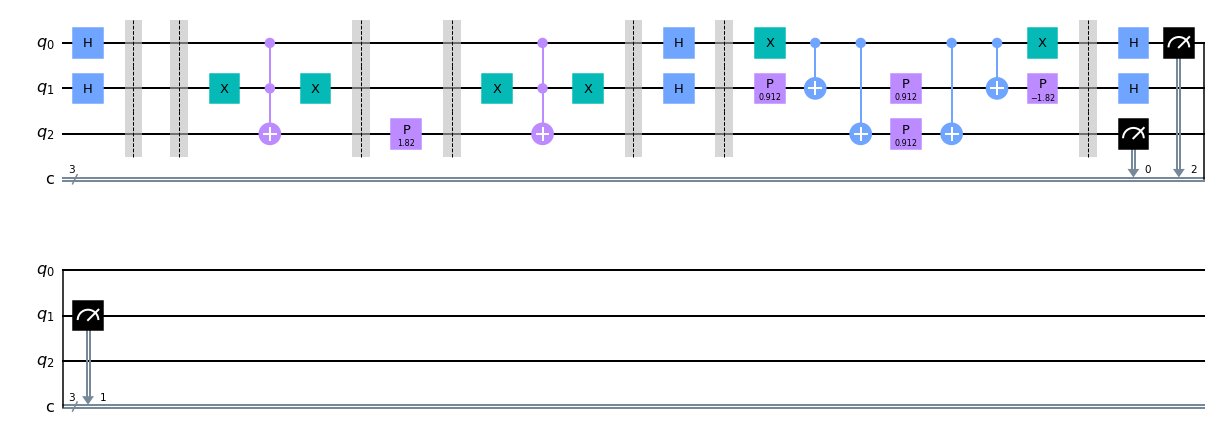

In [5]:
# The implementation is from paper and https://arxiv.org/pdf/1712.10231.pdf.
# I don't think the later one got alpha and beta right because they wrote the wrong formula for gamma

from qiskit import QuantumCircuit
from qiskit import Aer,execute, QuantumRegister,ClassicalRegister
from qiskit.visualization import plot_histogram


qc = QuantumCircuit(n+1, n+1)
# Initialize first n qubits
for i in range(n):
    qc.h(i)
qc.barrier()
for i in range(itr):
    # St(beta)
    oracle(qc,n, indices_to_mark) # turn state into |T>|1> + sum_i (|w_i>|0>) where w_i are NOT target state, T is the target state
    qc.p(beta[i],n) # when beta[i] = pi, this is simply a Z gate, so only has phase kickback on |T>|1> but not |w_i>|0>
    oracle(qc,n, indices_to_mark) # to uncompute the ancillary
    # St(alpha)
    for q in range(n):
        qc.h(q)
    qc.barrier()
    for q in range(n-1):
        qc.x(q)
#         qc.p(-alpha[i]/2, q)
    qc.p(-alpha[i]/2, n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.mct(list(range(n-1)), n)
    qc.p(-alpha[i]/2, n-1)
    qc.p(-alpha[i]/2, n)
#     qc.mct(list(range(n-1)), n-1)
    qc.mct(list(range(n-1)), n)
    qc.mct(list(range(n-1)), n-1)
    for q in range(n-1):
        qc.x(q)
#         qc.p(alpha[i], q)
    qc.p(alpha[i], n-1)
    qc.barrier()
    for q in range(n):
        qc.h(q)

qc.measure(range(n+1), range(n+1)[::-1]) # Measurement order is the reversed qubit order, I prefer to follow the qubit order
print("Looking for ", format(indices_to_mark, "0{:d}b".format(n)))
print("1-delta^2 = ", 1-d**2)
qc.draw(output='mpl')

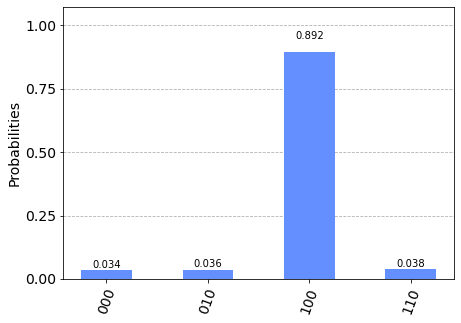

In [6]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator, shots=10000).result().get_counts()
plot_histogram(counts)

In [ ]:
indices_to_mark = 2
qc = QuantumCircuit(n+1, n+1)
for q in range(n):
    qc.h(q)
qc.barrier()
oracle(qc,n, indices_to_mark)
qc.p(beta[0],n)
oracle(qc,n, indices_to_mark)
for q in range(n):
    qc.h(q)
for q in range(n-1):
    qc.x(q)
qc.p(-alpha[0]/2, n-1)
qc.mct(list(range(n-1)), n-1)
qc.mct(list(range(n-1)), n)
# qc.p(-alpha[0]/2, n-1)
# qc.p(-alpha[0]/2, n)
# qc.mct(list(range(n-1)), n-1)
# qc.mct(list(range(n-1)), n)
# for q in range(n-1):
#     qc.x(q)
# qc.p(alpha[0], n-1)
# qc.barrier()
# for q in range(n):
#     qc.h(q)

statevector_simulator = Aer.get_backend('statevector_simulator')
qc_trans = transpile(qc, statevector_simulator, initial_layout = [0,1,2], optimization_level=0)
res_state = execute(qc_trans , backend=statevector_simulator, shots=10000).result().get_statevector(qc, decimals=3)
np.abs(res_state)**2, res_state

In [ ]:
indices_to_mark = 2
qc = QuantumCircuit(n+1, n+1)
for q in range(n):
    qc.h(q)
qc.barrier()
oracle(qc,n, indices_to_mark)
qc.p(beta[0],n)
oracle(qc,n, indices_to_mark)
for q in range(n):
    qc.h(q)
for q in range(n-1):
    qc.x(q)
qc.p(-alpha[0]/2, n-1)
qc.mct(list(range(n-1)), n-1)
qc.mct(list(range(n-1)), n)
qc.p(-alpha[0]/2, n-1)
qc.p(-alpha[0]/2, n)
qc.mct(list(range(n-1)), n-1)
qc.mct(list(range(n-1)), n)
for q in range(n-1):
    qc.x(q)
qc.p(alpha[0], n-1)
# qc.barrier()
for q in range(n):
    qc.h(q)

statevector_simulator = Aer.get_backend('statevector_simulator')
qc_trans = transpile(qc, statevector_simulator, initial_layout = [0,1,2][::-1], optimization_level=0)
res_state = execute(qc_trans , backend=statevector_simulator, shots=10000).result().get_statevector(qc, decimals=3)
np.abs(res_state)**2, res_state

In [ ]:
indices_to_mark = 0
alpha[0] = -np.pi
i = 0
qc = QuantumCircuit(n+1, n+1)
for q in range(n):
    qc.h(q)
for q in range(n-1):
    qc.x(q)
qc.p(-alpha[i]/2, n-1)
qc.mct(list(range(n-1)), n-1)
qc.mct(list(range(n-1)), n)
qc.p(-alpha[i]/2, n-1)
qc.p(-alpha[i]/2, n)
qc.mct(list(range(n-1)), n-1)
qc.mct(list(range(n-1)), n)
for q in range(n-1):
    qc.x(q)
qc.p(alpha[i], n-1)
for q in range(n):
    qc.h(q)

unitary_simulator = Aer.get_backend('unitary_simulator')
qc_trans = transpile(qc, unitary_simulator, initial_layout = [0,1,2], optimization_level=0)
job = execute(qc_trans, unitary_simulator)
job.result().get_unitary(qc_trans, decimals=3)

In [7]:
# Just copy paste the code above
def FP_Grover_circuit(n, indices_to_mark, itr, d):
    l = itr
    L = 2*l+1

    gamma_inverse = Chbshv_poly(1/L, 1/d)
    omega = 1 - Chbshv_poly(1/L, 1/d)**(-2)

    alpha =  mpm.zeros(1,l)
    beta = mpm.zeros(1,l)
    for i in range(l): # use i instead of j since python use 1j for sqrt(-1)
        alpha[i] = 2*mpm.acot(mpm.tan(2*mpm.pi*(i+1)/L) * mpm.sqrt(1-1/gamma_inverse**2))
        beta[l-(i+1)+1-1] = -alpha[i]

    # Convert to numpy
    gamma_inverse = np.array([gamma_inverse], dtype=complex)[0].real
    omega = np.array([omega], dtype=complex)[0].real
    alpha = np.array(alpha.tolist()[0], dtype=complex).real
    beta = np.array(beta.tolist()[0], dtype=complex).real
    
    r = QuantumRegister(n+1)
    qc = QuantumCircuit(r)
    for i in range(n):
        qc.h(i)
    qc.barrier()
    for i in range(itr):
        # St(beta)
        oracle(qc,n, indices_to_mark)
        qc.p(beta[i],n)
        oracle(qc,n, indices_to_mark)
        # St(alpha)
        for q in range(n):
            qc.h(q)
        qc.barrier()
        for q in range(n-1):
            qc.x(q)
        qc.p(-alpha[i]/2, n-1)
        qc.mct(list(range(n-1)), n-1)
        qc.mct(list(range(n-1)), n)
        qc.p(-alpha[i]/2, n-1)
        qc.p(-alpha[i]/2, n)
        qc.mct(list(range(n-1)), n-1)
        qc.mct(list(range(n-1)), n)
        for q in range(n-1):
            qc.x(q)
        qc.p(alpha[i], n-1)
        qc.barrier()
        for q in range(n):
            qc.h(q)

#     qc.measure(r,c[::-1])
    
    return qc



def FP_Grover_simulator(n, indices_to_mark, itr, d, shots=10000):
    l = itr
    L = 2*l+1
    omega = np.array([1 - Chbshv_poly(1/L, 1/d)**(-2)], dtype=complex)[0].real
    
    qc = FP_Grover_circuit(n, indices_to_mark, itr, d)

    simulator = Aer.get_backend('qasm_simulator')
    counts = execute(qc, backend=simulator, shots=shots).result().get_counts()
    succ_prob = counts[(format(indices_to_mark, '0{:d}b'.format(n))+'0')]/shots

    return succ_prob, omega

In [8]:
# Load IBMQ Account and choose a real backend
from qiskit import IBMQ
from qiskit import transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmq_belem'
backend = provider.get_backend(name)

In [22]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# for i in range(len(meas_calibs)):
#     meas_calibs[i] = transpile(meas_calibs[i],backend,initial_layout=[0,1,2])

job_meas = execute(meas_calibs, backend=backend,shots=8192,optimization_level=0)
job_monitor(job_meas)

cal_results = job_meas.result()
meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter

Job Status: job has successfully run


In [41]:
import measfilter as mf # package for measurement error filter
interested_qubits = [2,1,0] # Descending order because Qiskit's readout is little-endian
itr = 64
shots = 8192
file_address = 'Noise/'
readout = mf.collect_filter_data(backend, itr=itr,shots=shots,if_monitor_job=True,if_write=True,file_address=file_address)

Formal Installation
Job Status: job has successfully run


Qubit 2
Given Lambdas [0.9552 0.9721]


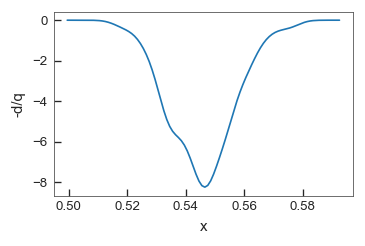

Final Accepted Posterior Lambdas
M: 8.24312 Maximizer: 0.546512 pi_obs = 36.7644 pi_Q(prior) = 4.46002
Progress: 99.997%
Accepted Number N: 4815, fraction 0.120
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94614435 0.86011172]
Posterior Lambda Mode [0.98254045 0.87677407]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.00254808
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


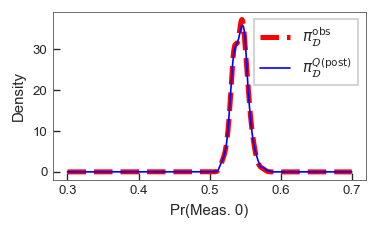

Qubit 1
Given Lambdas [0.9336 0.961 ]


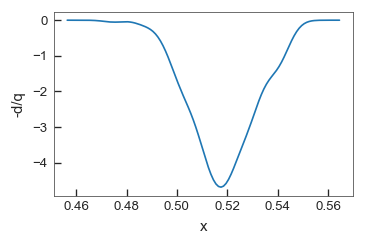

Final Accepted Posterior Lambdas
M: 4.68912 Maximizer: 0.517423 pi_obs = 33.6911 pi_Q(prior) = 7.18494
Progress: 99.997%
Accepted Number N: 8631, fraction 0.216
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.92737835 0.89399318]
Posterior Lambda Mode [0.94907533 0.91275196]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000606247
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


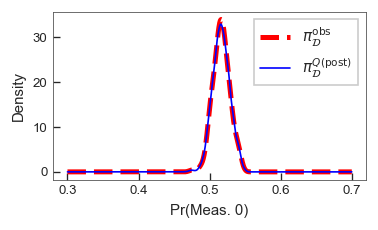

Qubit 0
Given Lambdas [0.9148 0.9415]


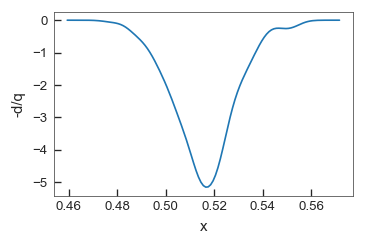

Final Accepted Posterior Lambdas
M: 5.15666 Maximizer: 0.516854 pi_obs = 35.4512 pi_Q(prior) = 6.87483
Progress: 99.997%
Accepted Number N: 7819, fraction 0.195
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.91534066 0.88779347]
Posterior Lambda Mode [0.93812581 0.90515037]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000924714
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


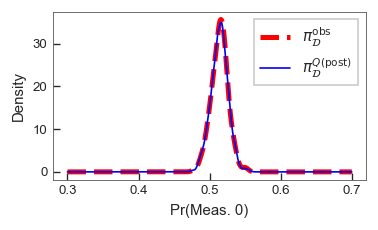

NameError: name 'mc' is not defined

In [42]:
Cons_filter = mf.MeasFilter(interested_qubits, file_address=file_address)
Cons_filter.inference(nPrior=40000, Priod_sd=0.1, seed=127, shots_per_point=1024*2)
our_filter = MeasurementFilter(Cons_filter.mat_mean, state_labels)

In [13]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

qc = FP_Grover_circuit(2, 2, 1, np.sqrt(0.2))

# qc_trans = transpile(qc, initial_layout = [1,3,2], optimization_level=0)
r = QuantumRegister(2+1)
qc2 = QuantumCircuit(r)
qc2.compose(qc, r)                  

tomo_circ = state_tomography_circuits(qc2, r)
job = execute(tomo_circ, backend=backend, shots=8192)
job_monitor(job)

C:\ProgramData\Anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


Job Status: job has successfully run


array([[ 9.56815448e-01+0.00000000e+00j, -7.49406900e-03-3.47243530e-02j,
         1.83112471e-02-9.75177476e-03j, -3.87776157e-03+1.04111301e-03j,
         4.54761010e-02-2.42826353e-02j,  2.90849120e-04-3.52024339e-03j,
         2.91953488e-03-6.60606831e-03j,  1.76441196e-03+2.26564452e-03j],
       [-7.49406900e-03+3.47243530e-02j,  2.60589313e-02+0.00000000e+00j,
         1.97374144e-03-2.90182851e-03j,  3.24429701e-06-4.85585340e-05j,
         2.40392261e-03-2.21767425e-04j,  9.31111277e-04-1.51583180e-03j,
        -6.92887620e-04-9.24038584e-04j, -1.25281808e-04+5.08203691e-05j],
       [ 1.83112471e-02+9.75177476e-03j,  1.97374144e-03+2.90182851e-03j,
         5.67273810e-03+0.00000000e+00j,  1.35086060e-03-1.02769768e-03j,
        -4.41559879e-04-3.93995934e-03j,  1.86407304e-03-5.63423714e-05j,
         4.00046300e-04-2.28805563e-04j,  9.85267418e-05+7.15593410e-05j],
       [-3.87776157e-03-1.04111301e-03j,  3.24429701e-06+4.85585340e-05j,
         1.35086060e-03+1.02769768e

In [48]:
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.quantum_info import state_fidelity
import qiskit.ignis.mitigation.measurement as mc

fitted = StateTomographyFitter(job.result(), tomo_circ)

correct_tomo_results = meas_fitter.filter.apply(job.result(), method='least_squares')
correct_fitted = StateTomographyFitter(correct_tomo_results, tomo_circ)


CB_tomo_results = our_filter.apply(job.result(), method='least_squares')
CB_fitted = StateTomographyFitter(CB_tomo_results, tomo_circ)

# den_mat = DensityMatrix(fitted.fit())
# den_mat.to_statevector(1e-3, 1e-1)


job_true = execute(qc, Aer.get_backend('statevector_simulator'))
true_state = job_true.result().get_statevector(qc)

state_fidelity(fitted.fit(), true_state), state_fidelity(correct_fitted.fit(), true_state), state_fidelity(CB_fitted.fit(), true_state)

(0.06240151104158624, 0.02037091989723421, 0.03373936910304189)

In [40]:
np.abs(true_state)**2

array([0.03515625, 0.89453125, 0.03515625, 0.03515625, 0.        ,
       0.        , 0.        , 0.        ])

In [ ]:
# ns = []
# ls = []
# probs = []
# omegas = []
# # d = 1/np.sqrt(5)
# d = np.sqrt(0.00001)
# maxitr = 10
# for n in range(5):
#     ns.append(n)
#     for itr in range(1, maxitr):
#         ls.append(itr)
#         succ_prob, omega = FP_Grover_simulator(n, 3, itr, d, shots=10000)
#         probs.append(succ_prob)
#         omegas.append(omega)
        
    
# ns = np.array(ns)
# ls = np.array(ls)
# probs = np.array(probs)
# omegas = np.array(omegas)
    
    
# plt.plot(ls, probs, label="Success Prob")
# plt.plot(ls, 1-np.square([d]*(maxitr-1)), label="LB")
# plt.xlabel("Number of Iterations")
# plt.ylabel("Probability")
# plt.xticks(range(1,maxitr))
# plt.legend()
# plt.show()


# plt.plot(ls[0.25>= omegas], probs[0.25>= omegas], label="Success Prob")
# plt.plot(ls[0.25>= omegas], 1-np.square([d]*(maxitr-1))[0.25>= omegas], label="LB")
# plt.xlabel("Number of Iterations")
# plt.ylabel("Probability")
# plt.xticks(np.array(range(1,maxitr))[0.25>= omegas])
# plt.legend()
# plt.show()

# print(omegas)
    
    
ns = list(range(3, 10)) # Number of Qubits
ls = list(range(1,41)) # Number of Iterations
d = np.sqrt(0.01)

# probs = np.zeros((len(ns), len(ls)), dtype = np.float64)
# omegas = np.zeros((len(ns), len(ls)), dtype = np.float64)
N,L = np.meshgrid(ns, ls)
probs = np.zeros(N.shape, dtype = np.float64)
omegas = np.zeros(N.shape, dtype = np.float64)
lambdas = np.zeros(N.shape, dtype = np.float64)
for j in range(len(ns)):
    for i in range(len(ls)):
        succ_prob, omega =FP_Grover_simulator(ns[j], 3, ls[i], d, shots=10000)
        probs[i,j] = succ_prob
        omegas[i,j] = omega
        lambdas[i,j] = 1/2**ns[j]
        print('Progress: {:.3%}'.format((j*len(ls)+i)/(len(ns)*len(ls))), end='\r')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.dpi"] = 150

fig = plt.figure()
# ax =  fig.add_subplot(1,2,1, projection='3d')
ax =  fig.add_subplot( projection='3d')
ax.scatter3D(N[lambdas>=omegas], L[lambdas>=omegas], probs[lambdas>=omegas], marker='*', color='blue')
ax.plot_wireframe(N, L, probs, color = 'lightgreen', rstride=1, cstride=1)
ax.set_xlabel('nQubits')
ax.set_xticks(ns)
ax.set_ylabel('nIters')
ax.set_yticks(ls[0::4])
ax.set_zlabel('$P_L$')
ax.set_title('Blue points are when $\lambda = M/N \geq \omega$')

ax.view_init(elev=30, azim=330)
plt.show()

In [ ]:
n = 4  # Number of Qubits
ls = list(range(1,21))  # Number of Iterations
ds = np.linspace(0.001, 0.1, 10)

D,L = np.meshgrid(ds, ls)
probs = np.zeros(D.shape, dtype = np.float64)
omegas = np.zeros(D.shape, dtype = np.float64)
lambdas = np.zeros(D.shape, dtype = np.float64)
for j in range(len(ds)):
    for i in range(len(ls)):
        succ_prob, omega = FP_Grover_simulator(n, 3, ls[i], ds[j], shots=10000)
        probs[i,j] = succ_prob
        omegas[i,j] = omega
        lambdas[i,j] = 1/2**n
        print('Progress: {:.3%}'.format((j*len(ls)+i)/(len(ds)*len(ls))), end='\r')

In [ ]:
fig = plt.figure()
# ax =  fig.add_subplot(1,2,1, projection='3d')
ax =  fig.add_subplot( projection='3d')
ax.scatter3D(D[lambdas>=omegas], L[lambdas>=omegas], probs[lambdas>=omegas], marker='*', color='blue')
ax.plot_wireframe(D, L, probs, color = 'lightgreen', rstride=1, cstride=1)
ax.set_xlabel('$\delta$')
ax.set_xticks(ds[0::2])
ax.set_ylabel('nIters')
ax.set_yticks(ls[0::2])
ax.set_zlabel('$P_L$')
ax.set_title('Blue points are when $\lambda = M/N \geq \omega$')

ax.view_init(elev=30, azim=330)
plt.show()

In [ ]:
# Load IBMQ Account and choose a real backend
from qiskit import IBMQ
from qiskit import transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmq_belem'
backend = provider.get_backend(name)

In [ ]:
import measfilter as mf # package for measurement error filter
interested_qubits = [1, 3, 2] # Descending order because Qiskit's readout is little-endian
itr = 64
shots = 8192
file_address = 'Noise/'
readout = mf.collect_filter_data(backend, itr=itr,shots=shots,if_monitor_job=True,if_write=True,file_address=file_address)

In [ ]:
Cons_filter = mf.MeasFilter(interested_qubits, file_address=file_address)
Cons_filter.inference(nPrior=40000, Priod_sd=0.1, seed=127, shots_per_point=1024*2)

In [ ]:
Cons_filter.mean()

In [ ]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter,MeasurementFilter)
qr = QuantumRegister(len(interested_qubits))
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for i in range(len(meas_calibs)):
    meas_calibs[i] = transpile(meas_calibs[i],backend,initial_layout=interested_qubits)

job_meas = execute(meas_calibs, backend=backend,shots=8192,optimization_level=0)
job_monitor(job_meas)

cal_results = job_meas.result()
meas_fitter = CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter

In [ ]:
FP_Grover_simulator(n, indices_to_mark, 3, d)

In [ ]:
n = 2 # Number of qubits, does not include the last ancillary qubit
indices_to_mark = 2 # An interger from 0 to 2**n
itr = 1 # Number of iterations
d = mpm.sqrt(0.2) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

qc = FP_Grover_circuit(n, indices_to_mark, itr, d)
circ_trans = transpile(qc, backend, initial_layout = [1, 3, 2], optimization_level=1) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans.depth()))
circ_trans.draw()

In [ ]:
job1 = execute(circ_trans, backend=backend, shots=8192, optimization_level=0)
job_monitor(job1)

In [ ]:
real_counts1 = job1.result().get_counts()
qis_counts1 = meas_filter.apply(real_counts1)
mean_counts1 = Cons_filter.filter_mean(real_counts1)

legend = ['Raw Data', 'Qiskit', 'CB Mean']
plot_histogram([real_counts1, qis_counts1, mean_counts1], legend=legend, figsize = (14,6), title="1 Iter")

In [ ]:
n = 2 # Number of qubits, does not include the last ancillary qubit
indices_to_mark = 2 # An interger from 0 to 2**n
itr = 2 # Number of iterations
d = mpm.sqrt(0.2) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

qc = FP_Grover_circuit(n, indices_to_mark, itr, d)
circ_trans = transpile(qc, backend, initial_layout = [1, 3, 2], optimization_level=1) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans.depth()))
circ_trans.draw()

In [ ]:
job2 = execute(circ_trans, backend=backend, shots=8192, optimization_level=0)
job_monitor(job2)

In [ ]:
real_counts2 = job2.result().get_counts()
qis_counts2 = meas_filter.apply(real_counts2)
mean_counts2 = Cons_filter.filter_mean(real_counts2)

legend = ['Raw Data', 'Qiskit', 'CB Mean']
plot_histogram([real_counts2, qis_counts2, mean_counts2], legend=legend, figsize = (14,6), title="2 Iters")

In [ ]:
n = 2 # Number of qubits, does not include the last ancillary qubit
indices_to_mark = 2 # An interger from 0 to 2**n
itr = 3 # Number of iterations
d = mpm.sqrt(0.2) # Success probability P_L >= 1 - d^2 if lambda = len(indices_to_mark)/2**n >= omega

qc = FP_Grover_circuit(n, indices_to_mark, itr, d)
circ_trans = transpile(qc, backend, initial_layout = [1, 3, 2], optimization_level=1) # Optimization level from 0 to 3, short circuit depth
print("Circuit Depth is {:d}".format(circ_trans.depth()))
circ_trans.draw()

In [ ]:
job3 = execute(circ_trans, backend=backend, shots=8192, optimization_level=0)
job_monitor(job3)

In [ ]:
real_counts3 = job3.result().get_counts()
qis_counts3 = meas_filter.apply(real_counts3)
mean_counts3 = Cons_filter.filter_mean(real_counts3)

legend = ['Raw Data', 'Qiskit', 'CB Mean']
plot_histogram([real_counts3, qis_counts3, mean_counts3], legend=legend, figsize = (14,6), title="3 Iters")